# RFM模型分析
 RFM的含义：
​
- R（Recency）：客户最近一次交易时间的间隔。R值越大，表示客户交易发生的日期越久，反之则表示客户交易发生的日期越近。
- F（Frequency）：客户在最近一段时间内交易的次数。F值越大，表示客户交易越频繁，反之则表示客户交易不够活跃。
- M（Monetary）：客户在最近一段时间内交易的金额。M值越大，表示客户价值越高，反之则表示客户价值越低。
 
RFM分析就是根据客户活跃程度和交易金额的贡献，进行客户价值细分的一种方法。
​
首先构建RFM表。

---

**RFM** is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in retail and professional services industries

RFM stands for the three dimensions:

1. Recency – How recently did the customer purchase?
2. Frequency – How often do they purchase?
3. Monetary Value – How much do they spend?


Before starting RFM analysis we need to set objective and outcome of analysis, for this example goal is to define class of customer example - Platinum, Gold and Silver.
1. Platinum customer - frequent and more revenue generator.
2. Gold customer - frequent but less revenue generator.
3. silver customer - less frequent and less revenue generator.

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")
plt.style.use('bmh')

Duplicate key in file PosixPath('/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 768 ('font.family  : sans-serif')
Duplicate key in file PosixPath('/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 769 ('font.sans-serif : SimHei, DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 770 ('axes.unicode_minus : False')


In [2]:
df = pd.read_csv('data.csv')

# 将列名中的空格和横杠转换为下划线
df.columns = df.columns.str.replace(' ', '_').str.replace('-', '_').str.lower()

df = df.query('quantity>0 and unitprice>0')
# 将日期字符串转换为 datetime 对象
df['invoicedate'] = pd.to_datetime(df['invoicedate'].str.split(' ',expand=True).iloc[:,0])
#df.drop_duplicates(subset=['customerid','invoiceno'], keep="first", inplace=True) 

# Post Code 字段含有很多缺失值，删掉
df.dropna(subset=['customerid'],how='all',inplace=True)

# 增加用于分组的字段
df['year'] = df.invoicedate.dt.year
df['month'] = df.invoicedate.dt.month
df['months'] = df.year.astype(str) + '-' + df.month.astype(str)
df['totalcost'] =  df['unitprice'] * df['quantity']

In [3]:
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,year,month,months,totalcost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,2010,12,2010-12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,2010,12,2010-12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,2010,12,2010-12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,2010,12,2010-12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,2010,12,2010-12,20.34


In [4]:
df[["quantity"]] = df[["quantity"]].astype(int)
rfm = df.pivot_table(
    index='customerid',
    values = ["invoiceno","totalcost","invoicedate"],
    aggfunc={
        "invoiceno": pd.Series.nunique,
        "totalcost" :"sum",
        "invoicedate": "max"
    }
)

# 所有用户最大的交易日期为标准，求每笔交易的时间间隔即为R
rfm['Recency'] = (rfm.invoicedate.max() - rfm.invoicedate) / np.timedelta64(1, 'D')

# # 每个客户的总销量即为F，总销售额即为M
rfm.rename(columns={
        "invoiceno": "Frequency",
        "totalcost": "Monetary"
    }, inplace = True)
rfm.head()

,invoicedate,Frequency,Monetary,Recency
customerid,,,,
12346.0,2011-01-18,1,77183.60,325.0
12347.0,2011-12-07,7,4310.00,2.0
12348.0,2011-09-25,4,1797.24,75.0
12349.0,2011-11-21,1,1757.55,18.0
12350.0,2011-02-02,1,334.40,310.0


如最近在做用户调研，根据用户的打分，将用户进行归类，在实际操作中，将用户归为三类（0-6一类，7-8一类等）

接着对客户价值进行标注，将客户分为8个等级。

In [5]:
# 基于平均值做比较，超过均值为1，否则为0
rfm[['Recency','Frequency','Monetary']].apply(lambda x:(x-x.mean())/x.std())

def rfm_func(x):
    level = x.apply(lambda x:'1'if x>0 else '0')
    level = level.Recency + level.Frequency + level.Monetary
    d = {
        "111": "重要价值客户",
        "011": "重要保持客户",
        "101": "重要挽留客户",
        "001": "重要发展客户",
        "110": "一般价值客户",
        "010": "一般保持客户",
        "100": "一般挽留客户",
        "000": "一般发展客户"
    }
    result = d[level]
    return result

rfm['label']= rfm[['Recency','Frequency','Monetary']].apply(lambda x:(x-x.mean())/x.std()).apply(rfm_func, axis=1)
rfm.head()

,invoicedate,Frequency,Monetary,Recency,label
customerid,,,,,
12346.0,2011-01-18,1,77183.60,325.0,重要挽留客户
12347.0,2011-12-07,7,4310.00,2.0,重要保持客户
12348.0,2011-09-25,4,1797.24,75.0,一般发展客户
12349.0,2011-11-21,1,1757.55,18.0,一般发展客户
12350.0,2011-02-02,1,334.40,310.0,一般挽留客户


对重要价值客户和非重要价值客户进行可视化展示

<AxesSubplot:xlabel='Frequency', ylabel='Recency'>

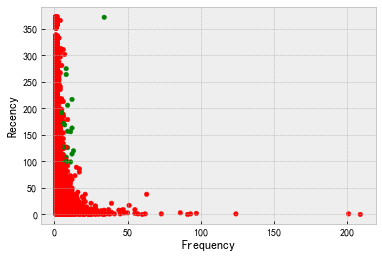

In [6]:
rfm.loc[rfm.label == "重要价值客户", "color"] = "g"
rfm.loc[~(rfm.label == "重要价值客户"),'color'] = "r"
rfm.plot.scatter("Frequency", "Recency", c=rfm.color)

但是股票交易场景下，对于客户的分层和定义会不一样。

我们常使用kmeans做聚类，再进一步分析

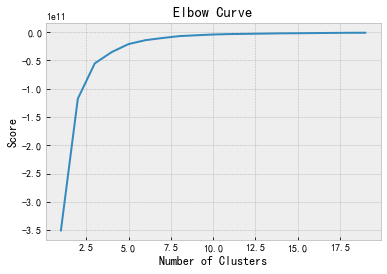

In [7]:
# get right number of cluster for K-means so we neeed to loop from 1 to 20 number of cluster and check score.
#Elbow method is used to represnt that. 
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]

rfm_segmentation = rfm[['Recency','Frequency','Monetary']].copy()
score = [kmeans[i].fit(rfm_segmentation).score(rfm_segmentation) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

通过RFM识别不同的客户群体，能够衡量客户价值和客户利润创收能力，可以指定个性化的沟通和营销服务，为更多的营销决策提供有力支持，为企业创造更大的利益。

In [8]:
#fitting data in Kmeans theorem.
kmeans = KMeans(n_clusters=3, random_state=0).fit(rfm_segmentation)

# this creates a new column called cluster which has cluster number for each row respectively.
rfm_segmentation['cluster'] = kmeans.labels_

#check our hypothesis
rfm_segmentation[rfm_segmentation.cluster == 0].head(10)

,Recency,Frequency,Monetary,cluster
customerid,,,,
12347.0,2.0,7,4310.00,0
12348.0,75.0,4,1797.24,0
12349.0,18.0,1,1757.55,0
12350.0,310.0,1,334.40,0
12352.0,36.0,8,2506.04,0
12353.0,204.0,1,89.00,0
12354.0,232.0,1,1079.40,0
12355.0,214.0,1,459.40,0
12356.0,22.0,3,2811.43,0


<AxesSubplot:xlabel='cluster', ylabel='Recency'>

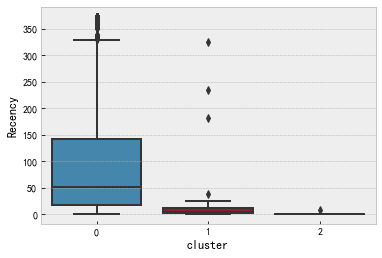

In [9]:
'''
cluster 0 have high recency rate which is bad. cluster 1 and cluster 2 having low so they are in race of platinum
and gold customer.
'''
sns.boxplot(x=rfm_segmentation.cluster,y=rfm_segmentation.Recency)

<AxesSubplot:xlabel='cluster', ylabel='Frequency'>

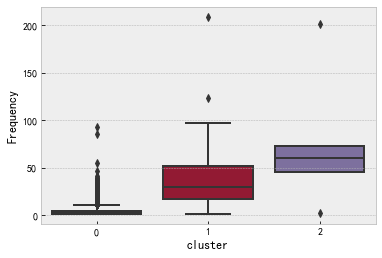

In [10]:
sns.boxplot(x=rfm_segmentation.cluster,y=rfm_segmentation.Frequency)

<AxesSubplot:xlabel='cluster', ylabel='Monetary'>

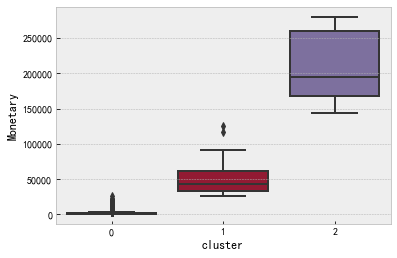

In [11]:
sns.boxplot(x=rfm_segmentation.cluster,y=rfm_segmentation.Monetary)

Based on customer Segmentation we found out cluster 2 is Platinum customers Cluster 1 is Gold Customers Cluster 3 is Silver Customers

In [12]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)

#lower the recency, good for store..
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)

#higher value of frequency and monetary lead to a good consumer. here higher value = 1 in reverse way.

def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [13]:
'''
quantile is like 25% , 50% and 75% level of values. example if we have 100 values first 25 in 1st quartile 25% 
then second contain next 25% which is 50% and there after next 25% which is 75% and 4th quartile is more than 75% 
values.
'''
quantile = rfm.quantile(q=[0.25,0.5,0.75])
quantile

,Frequency,Monetary,Recency
0.25,1.0,307.415,17.00
0.50,2.0,674.485,50.00
0.75,5.0,1661.740,141.75


In [14]:
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore,args=('Recency',quantile))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantile))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantile))

In [15]:
quantile.to_dict()

{'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 307.41499999999996,
  0.5: 674.4849999999999,
  0.75: 1661.7400000000007},
 'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 141.75}}

In [16]:
#calculate RFM score..

rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore
customerid,,,,,,,,
12346.0,325.0,1,77183.60,1,4,4,1,441
12347.0,2.0,7,4310.00,0,1,1,1,111
12348.0,75.0,4,1797.24,0,3,2,1,321
12349.0,18.0,1,1757.55,0,2,4,1,241
12350.0,310.0,1,334.40,0,4,4,3,443


In [17]:
'''
Another possibility is to combine the scores to create one score (eg. 4+1+1). This will create a score 
between 3 and 12. Here the advantage is that each of the scores got same importance. However some scores 
will have many segments as constituents (eg - 413 ad 431)
'''

rfm_segmentation['Total_score'] = rfm_segmentation['R_Quartile'] + rfm_segmentation['F_Quartile'] + \
rfm_segmentation['M_Quartile']

In [18]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore,Total_score
customerid,,,,,,,,,
12346.0,325.0,1,77183.60,1,4,4,1,441,9
12347.0,2.0,7,4310.00,0,1,1,1,111,3
12348.0,75.0,4,1797.24,0,3,2,1,321,6
12349.0,18.0,1,1757.55,0,2,4,1,241,7
12350.0,310.0,1,334.40,0,4,4,3,443,11


In [19]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==1]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==1]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='134']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='344']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))

Best Customers:  456
Loyal Customers:  872
Big Spenders:  1085
Almost Lost:  34
Lost Customers:  208
Lost Cheap Customers:  444


In [20]:
rfm_segmentation.sort_values(by=['RFMScore', 'Monetary'], ascending=[True, False])

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore,Total_score
customerid,,,,,,,,,
14646.0,1.0,73,280206.02,2,1,1,1,111,3
18102.0,0.0,60,259657.30,2,1,1,1,111,3
17450.0,8.0,46,194550.79,2,1,1,1,111,3
14911.0,1.0,201,143825.06,2,1,1,1,111,3
14156.0,9.0,55,117379.63,1,1,1,1,111,3
...,...,...,...,...,...,...,...,...,...
17102.0,261.0,1,25.50,0,4,4,4,444,12
15823.0,372.0,1,15.00,0,4,4,4,444,12
17763.0,263.0,1,15.00,0,4,4,4,444,12


In [21]:
rfm_segmentation.groupby('RFMScore')['Monetary'].mean()

RFMScore
111    9547.540000
112    1286.331270
113     511.270000
114     253.920000
121    2910.558864
          ...     
434     214.629524
441    8910.267273
442     994.800000
443     415.126847
444     165.206036
Name: Monetary, Length: 61, dtype: float64

In [22]:
rfm_segmentation.groupby('Total_score')['Monetary'].mean()

Total_score
3     9547.540000
4     4164.127041
5     2431.437589
6     1456.718650
7     1201.251631
8      782.687576
9      717.969937
10     384.770298
11     288.072454
12     165.206036
Name: Monetary, dtype: float64

<AxesSubplot:xlabel='Total_score'>

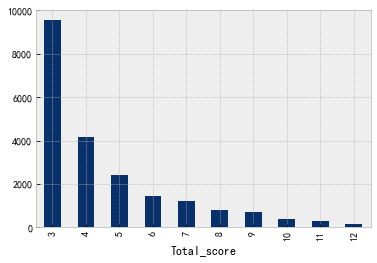

In [23]:
'''
Based on Monetary we see Total_score 3,4,5 have highest value which is good for model. because it could have
combination of values such as 111, 121, 122 etc.
'''
rfm_segmentation.groupby('Total_score')['Monetary'].mean().plot(kind='bar', colormap='Blues_r')

<AxesSubplot:xlabel='Total_score'>

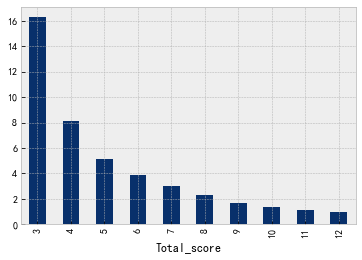

In [24]:
'''
Based on Frequncy we see Total_score 3,4,5 have highest value which is good for model. because it could have
combination of values such as 111, 121, 122 etc.
'''
rfm_segmentation.groupby('Total_score')['Frequency'].mean().plot(kind='bar', colormap='Blues_r')

<AxesSubplot:xlabel='Total_score'>

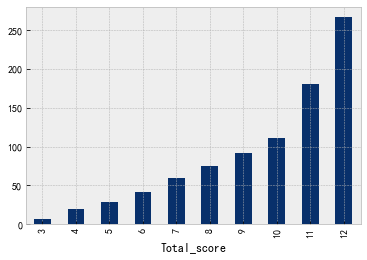

In [25]:
'''
Based on Recency we see Total_score 10,11,12 have highest value which is good for model. because it could have
combination of values such as 444, 434, 334 etc.
'''

rfm_segmentation.groupby('Total_score')['Recency'].mean().plot(kind='bar', colormap='Blues_r')

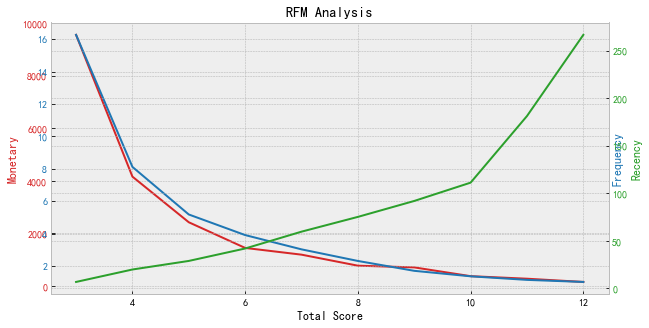

In [27]:
m = rfm_segmentation.groupby('Total_score')['Monetary'].mean()
f = rfm_segmentation.groupby('Total_score')['Frequency'].mean()
r = rfm_segmentation.groupby('Total_score')['Recency'].mean()

plt.style.use('bmh')
fig, ax1 = plt.subplots(figsize = [10,5])

color = 'tab:red'
ax1.plot(m.index, m.values,color=color)
ax1.set_title('RFM Analysis')
ax1.set_xlabel('Total Score')
ax1.set_ylabel('Monetary', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(f.index, f.values,color=color)
ax2.set_ylabel('Frequency', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax2.twinx()

color = 'tab:green'
ax3.plot(r.index, r.values,color=color)
ax3.set_ylabel('Recency', color=color)
ax3.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()